In [93]:
import re
import requests
import json
import os
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import matplotlib.pyplot as plt

from operator import itemgetter
from nltk import tokenize, sent_tokenize, RegexpTokenizer, ngrams
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, normalize, Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
def liwc_analysis(text):
    X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
    X_API_KEY = '584055def86167059a1c1d34'

    header = {}
    header['X-API-KEY'] = X_API_KEY
    header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
    header['Content-type'] = 'application/json'

    url = 'https://api-v3.receptiviti.com/v3/api/content'
    
    
    payload = {"content_source": 0,
                              "language_content": text
          }
    try:    
        r = requests.post(url, headers=header, json=payload, timeout=45)
        json_to_dump = json.loads(r.text)
        return json_to_dump['liwc_scores']['categories']

    except Exception as e:
        print("error")
        pass


def create_liwc_df(text,temp):
    for i in range(1,len(text)):
        print(text[i])
        text = liwc_analysis(text[i])
        temp_obj = pd.DataFrame(data=text, index=[i])
        temp = pd.concat((temp, temp_obj), axis=0)
    return temp

In [3]:
def generate_wordcloud(text,title,max_words = 50):
    words = text['post_text'].str.cat()
    
    wordcloud = WordCloud(max_words=max_words,background_color='white', max_font_size=50).generate(words)

    # Display the generated image:
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def generate_CDF(data):

    temp_depression = data['num_words_post'].value_counts().sort_index()
    temp_depression /= np.sum(temp_depression.values)
    depression_indice_list = temp_depression.index
    temp_depression = temp_depression.reset_index().drop('index',axis=1)
    CDF_depression = np.zeros(len(temp_depression))
    CDF_depression[0] = temp_depression.iloc[0,0]


    for i in range(1, len(temp_depression)):
        CDF_depression[i] = CDF_depression[i-1] + temp_depression.iloc[i,0]
    return CDF_depression, depression_indice_list

    
    
def vector_transformers(text_column):

    count_vect = CountVectorizer()
    post_text = count_vect.fit_transform(text_column)

    tfidf_transformer = TfidfTransformer()
    post_text_tfidf = tfidf_transformer.fit_transform(post_text)

    return post_text_tfidf


# Clean dataset
def clean_data(dataset):
#     dataset = dataset[dataset['subreddit'] != 'depression']
#     dataset = dataset[dataset['subreddit'] != 'AskReddit']
    dataset['post_text'] = dataset['post_text'].fillna('')
    dataset = dataset[dataset['post_text'] != '[removed]']
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\r', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\n', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace("\'", ""))
    dataset = dataset.dropna()
    dataset = dataset.reset_index()

    return dataset

def post_to_wordlist(post, remove_stopwords=True, split=False):
    
    post = re.sub("[^a-zA-Z]"," ", post)
    words = post.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if split:
        return words
    else:
        return (' '.join(words))

In [4]:
# Load the data and clean it.
# if you have internet connection use the markdown below instead of this code block
# use this one only if you have the data file saved on your machine
df = pd.read_csv(r'/Users/giladgecht/Downloads/temp.csv')

df = shuffle(df)
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

df = pd.read_csv('temp.csv')
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

In [5]:
target = '_subreddit'
cols = '_title'

X = df[cols]
y = df[target]

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [8]:
print("Accuracy Score:",score)
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

Accuracy Score: 0.8677248677248677
[[1609  143]
 [ 232  851]]
AUC Score: 0.9358376140228645


In [9]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['reddit' 'redditors' 'actuslly' 'did' 'thing' 'movie' 'outlook' 'gravity'
 'member' 'game']

Largest Coefs: 
['depression' 'therapy' 'suicide' 'depressed' 'therapist' 'bed' 'suicidal'
 'feels' 'anymore' 'feel']



In [10]:
# Load main dataset and clean it by removing deleted posts and filling presumed posts with pictures with ''
# Apply the trained LinearSVC classifier on the dataset
whole_data = pd.read_csv(r'/Users/giladgecht/PycharmProjects/DepressionResearch/Create_Data/SubmissionsDF.csv',index_col=0)
whole_data = clean_data(whole_data)
whole_data['predicted'] = svc.predict(count_vect.transform(whole_data['title']))
whole_data.shape

(276500, 18)

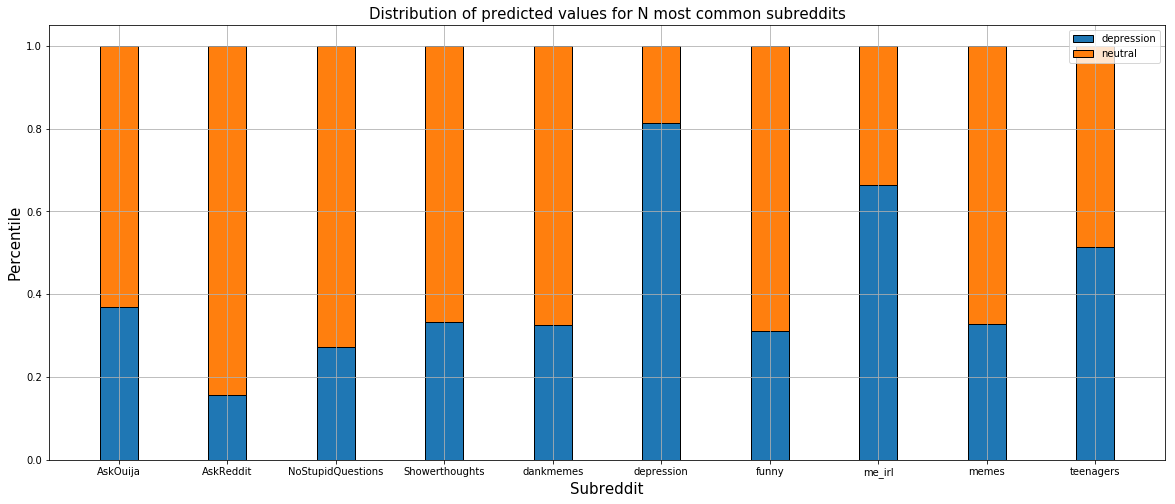

In [11]:
# for the top n common subreddits (probably depression related)
# plot the distribution of predicted neutral posts vs depression posts 
# i.e. subreddit = 'depression', num_posts = 3000, predicted_1 = 2500 (depression), predicted_0 


N = 10
most_common_subreddits = list(whole_data['subreddit'].value_counts().nlargest(N).keys())
most_common_subreddits = whole_data[whole_data['subreddit'].isin(most_common_subreddits)]

temp = most_common_subreddits['subreddit'].value_counts()
sum_subreddit_dict = temp.to_dict()

temp = most_common_subreddits.groupby(['subreddit','predicted'], as_index=False).agg({"submission_id":"count"})
temp['appearance'] = temp['subreddit'].apply(lambda x: sum_subreddit_dict[x])
temp['submission_id'] /= temp['appearance']

pred_depression = temp.iloc[1::2,:]
pred_neutral = temp.iloc[::2,:]

ind = np.arange(N)
width = .35
plt.figure(figsize=(20,8))
p1 = plt.bar(ind, pred_depression['submission_id'], width, edgecolor='k', label='depression')
p2 = plt.bar(ind, pred_neutral['submission_id'], width, edgecolor='k', label='neutral',bottom=pred_depression['submission_id'])


plt.title("Distribution of predicted values for N most common subreddits", size=15)
plt.ylabel('Percentile',size=15)
plt.xlabel('Subreddit', size=15)
plt.xticks(ind, list(pred_depression['subreddit'].values))
plt.legend()
plt.grid()
plt.show()


In [12]:
# Distribution of predicted values
whole_data['predicted'].value_counts()

0    167660
1    108840
Name: predicted, dtype: int64

In [13]:
# Filter out the data by noise
# Subreddits with less than 50 appearences are dropped out 
counts = whole_data['subreddit'].value_counts()
popular_subreddits = counts[counts.values >= 50].keys()
whole_data = whole_data[(whole_data['subreddit'].isin(popular_subreddits))]

In [14]:
# Number of UNIQUE subreddits left after being filtered
subreddits = set(whole_data['subreddit'])
len(subreddits)

830

In [15]:
# Apply a second filter,
# by checking the tendency of a certain subreddit to be either depression or neutral
# if its over 70% towards a certain side, append to the appropriate list

neutral_subreddits = []
depression_subreddits = []
for i in subreddits:
    values = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values
    sum_values = np.sum(whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values)
    values_perc = values/sum_values
    value1 = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values[0]
    if whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().keys()[0] == 0:
        if values_perc[0] >= 0.7:
            neutral_subreddits.append(i)
    else:
        if values_perc[0] >= 0.7:
            depression_subreddits.append(i)

In [16]:
# Distribution of depression subreddits 
whole_data[whole_data['subreddit'].isin(depression_subreddits)]['subreddit'].value_counts()

depression             21304
SuicideWatch            1980
Anxiety                 1457
mentalhealth             657
selfharm                 626
relationship_advice      603
relationships            441
lonely                   390
BreakUps                 285
DoesAnybodyElse          274
Needafriend              233
MakeNewFriendsHere       198
TrueOffMyChest           197
selfimprovement          182
r4r                      176
dirtykikpals             175
Vent                     166
depression_help          146
dogs                     124
AmItheAsshole            118
stopsmoking              106
ForeverAloneDating        93
Assistance                89
CPTSD                     79
antidepressants           72
depressed                 63
sleep                     56
DAE                       55
TalkTherapy               54
Name: subreddit, dtype: int64

In [17]:
print("The Filtered Neutral Subreddits Are:\n\n",neutral_subreddits)
print(20*"-")
print("The Filtered Depression Subreddits are:\n\n", depression_subreddits)

The Filtered Neutral Subreddits Are:
 ['HomeImprovement', 'MovieDetails', 'DunderMifflin', 'masseffect', 'uberdrivers', 'halloween', 'translator', 'gameofthrones', 'gamingsuggestions', 'FashionReps', 'webdev', 'SuggestALaptop', 'AndroidQuestions', 'DMAcademy', 'ukpolitics', 'WorldofTanks', 'vegan', 'shittyrainbow6', 'analog', 'ShouldIbuythisgame', 'walmart', 'NoStupidQuestions', 'Filmmakers', 'playark', 'politics', 'oculus', 'worldnews', 'soccer', 'gorillaz', 'dankchristianmemes', 'Conservative', 'WouldYouRather', 'PoliticalHumor', 'BokuNoHeroAcademia', 'oddlysatisfying', 'The3Million', 'Piracy', 'sbubby', 'MaddenUltimateTeam', 'AbsoluteUnits', 'playrust', 'tea', 'starterpacks', 'ladyladyboners', 'Art', 'Entrepreneur', 'Twitch', 'photoshopbattles', 'SuddenlyGay', 'nfl', 'totalwar', 'Pathfinder_RPG', 'therewasanattempt', 'HistoryMemes', 'disneyvacation', 'Futurology', 'Xcom', 'AskReddit', 'DivinityOriginalSin', 'fireemblem', 'smashbros', 'StarWars', 'Fishing', 'androidapps', 'computers'

In [18]:
# Filtered by hand depression-related subreddits
depression_subreddit_filtered_list = ['depression_help', 'lonely', 'SuicideWatch', 'depression',
                                      'selfharm', 'mentalhealth', 'offmychest', 'Anxiety',]

In [19]:
# Split the dataframe to neutral and depressed by the filtered subreddits
depression_df = whole_data[whole_data['subreddit'].isin(depression_subreddit_filtered_list)]
neutral_df = whole_data[whole_data['subreddit'].isin(neutral_subreddits)]

In [20]:
# Get the list of all unique users for each type of dataset
depression_names = list(set(depression_df['user_name']))
neutral_names = list(set(neutral_df['user_name']))

In [21]:
# Merge them back to a single dataframe
full_df = pd.concat([depression_df,neutral_df],axis=0)
full_df.shape

(80844, 18)

In [22]:
# Filter out people who havn't posted in both types of subreddits (Depression/Neutral) in the current dataset
both = []
for i in depression_names:
    if i in neutral_names:
        both.append(i)

In [23]:
full_df = full_df[full_df['user_name'].isin(both)]
full_df = full_df.sort_values(by=['user_name','date_created'],ascending=False)
full_df['num_distinct_words'] = full_df['post_text'].apply(lambda x: len(set(x.split())))

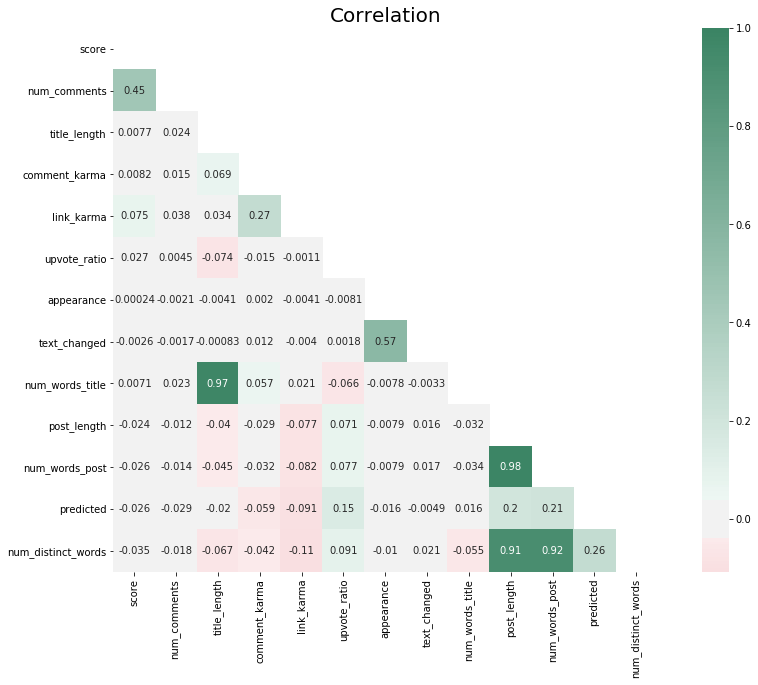

In [24]:
df_corr = full_df._get_numeric_data()

mask = np.zeros_like(df_corr.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(10,150,as_cmap=True)

plt.figure(figsize=(16,10))
sb.heatmap(df_corr.corr(),cmap=cmap,annot=True,mask = mask,square = True,center = 0)
plt.title('Correlation',size=20)
plt.show()

In [25]:
# Create a colum comprised of tri-grams of the post's text
full_df['tokenized'] = full_df['post_text'].apply(lambda x: x.split())

blabla = []
for row in full_df['tokenized']: # Iterate over each row
    generated_3grams = []

    for word in row: # iterate over each word in the row
        generated_3grams.append(list(ngrams(word, 3, pad_left=True, pad_right=False, left_pad_symbol='_')))

    temp_bla = []
    for i in generated_3grams:# iterate over each list in the 3gram
        for j in i: # iterate over each tuple in the current list
            temp_bla.append(j)
    blabla.append(temp_bla)
    
full_df['trigrams'] = 0 
full_df = full_df.reset_index().drop('index',axis=1)

for i in range(len(full_df['trigrams'])):
    full_df['trigrams'][i] = blabla[i]
    
for i in range(len(full_df['trigrams'])):
    ng_list_3grams = full_df['trigrams'][i]
    for idx,val in enumerate(full_df['trigrams'][i]):
        ng_list_3grams[idx] = ''.join(val)
        
        
    full_df['trigrams'][i] = ng_list_3grams

full_df['trigrams'] = full_df['trigrams'].apply(lambda x: ' '.join(x))
full_df = full_df.drop('tokenized',axis=1)

In [26]:
# Load the existing liwc dataframe, since there might have been a few errors in the creation,
# we'll drop the Nulls and eventually create a set of the existing submission ids
liwc = pd.read_csv('temp2.csv',index_col = 0)
liwc = liwc.dropna()
liwc_submission_ids = list(set(liwc['submission_id']))
liwc.shape

(22447, 86)

In [27]:
# TODO: Check if this block is needed, block above might provide already the needed columns
# Create a sample liwc object to get all the relevant features
X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
X_API_KEY = '584055def86167059a1c1d34'

header = {}
header['X-API-KEY'] = X_API_KEY
header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
header['Content-type'] = 'application/json'

url = 'https://api-v3.receptiviti.com/v3/api/content'

body = """ 
i feel like i’ve waisted it trying to get his help. i can’t connect with him, which makes me feel less like i can open up to him. i don’t particularly enjoy my time there, and i often don’t feel like i’ve gained anything from our sessions.i haven’t gone to see him in a few months. since then i’ve had about 10 mental breakdowns where i’ve felt as though i was hopeless, 5 panic attacks while driving, and like a heck ton of panic attacks at home. whenever i drive i just start crying uncontrollably. whenever i’m at home i hate myself and all i can think about is how i’d rather be dead than living with myself. i keep having panic attacks at work, my work performance is pretty crap because i can’t focus, and i fall asleep while sitting up because i can’t find peace at night.my grades have drastically dropped, and my dad tells me that it’s all my fault, and that i only want a new counselor because my friend has a counselor so i think it’s cool. i hate myself so much right now, and nobody i know has been able to comfort me.i feel so deprived of support, and i just want this feeling to end. if someone told me that they were here for me and gave me a hug i think i would implode on myself, because nobody has held me while i cried or told me that they would be here for me while i struggle with anxiety and depression
"""
#payload = {"content_source": 0,
#                               "language_content": unicode(TextFileContents, errors='ignore')

payload = {"content_source": 0,
                              "language_content": body
          }


#print payload

r = requests.post(url, headers=header, json=payload, timeout=45)
#print r.text
json_to_dump = json.loads(r.text)
# except e as err:
#         print("error"+err.msg)
liwc_cols = list(json_to_dump['liwc_scores']['categories'].keys())

In [28]:
# Keep only the posts where the submission id is in the analyzed liwc dataframe
# eventually we'll merge the 2 dataframes by their submission ids
full_df = full_df[full_df['submission_id'].isin(liwc_submission_ids)]
full_df = pd.merge(full_df, liwc,how='left', on='submission_id',)

In [29]:
# Find by using regular expressions all the sentences
# which are built in the following way: "i ...... depress/ed/ion/ants and so on"

count = 0
sentences = []
post = []
subreddits = []
for row in full_df.iterrows():
    
    sentence = row[1]['post_text']
    bla = re.findall(r'\bi\s.*\bdepress[\w]*\b', sentence)
    if len(bla) > 0:
        print(bla)
#         print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        post.append(row[1]['submission_id'])
        subreddits.append(row[1]['subreddit'])
        sentences.append(sentence)
        count += 1
print(count)

['i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucked up or killing myself.that went on for a few weeks and then i decided

['i live with my 24 year old girlfriend, i’m 23 and we are both depressed.my depression drowned a bit since i have an okay job, wake up early everyday and stopped some bad habits. it’s still there, but not on the surface anymore.my girlfriend is very depressed']
Subreddit: depression
----------
['i broke up. i think the faulty one was me because i didnt like certain little things about his personality and wanted him to be perfect in my eyes, therefore treated him poorly from time to time, even if it was mild. things werent so good the last 4-5 months but we managed somehow. eventually he drew attention to it and we broke up. now, when you spend your 1,5 years with someone (we were highschool sweethearts, also he was my first boyfriend), your life sort of forms around them. breaking up feels like ripping your arm off and leaving it on the road as you try to carry on. i have so many memories with him. my life was basically him. now my problematic & obsessive personality is ruining everyt

['i don’t know i just feel like really down and i really hate it... i mean usually i’m like really depressed']
Subreddit: depression
----------
['i kinda got the feeling that i don’t have the right to be depressed']
Subreddit: depression
----------
['i just can’t stand this anymore... struggling w/ depression']
Subreddit: depression
----------
['i can get the pressure right. i no longer have any hope for the future or desire to live. i am going to really miss my dog though, who is also going through depression']
Subreddit: SuicideWatch
----------
['i can get the pressure right. i no longer have any hope for the future or desire to live. i am going to really miss my dog though, who is also going through depression']
Subreddit: depression
----------
['i cant stop worrying and shaking and crying about this. last friday, my (f23) brother (m19) calls me up at work that he didnt mean to find it, but he came across a note book of my sister with some pretty horrid stuff written inside. drawing

['i always said that if he were to change his mind, we would split up as friends. thats where we are right now. i am in a hibernation of sorts. we are still living together, but he is away for days at a time for work stuff. my uni started yesterday, and i still havent been in classes. we has assignment over the holiday, which i have still not finished. now we have another one which is due in 2 days. im sitting in front of my computer, unable to do anything. my brain is just a fog, and im having crying outbreaks. im studying to become a teacher, but im not sure i want this anymore. ive had problems at school right from the beginning, my depression']
Subreddit: depression
----------
['i am writing this, i should be writing an essay. its due in 12 h, and i have barely started. no matter how hard i read, i dont understand the subject. i feel the clump in my stomach growing, its getting to the point of where i want to throw up. i hate that this happens every time i have to perform, do a tes

Subreddit: depression
----------
['i feel like quitting my life, i keep telling myself that i need to be alive when the next season of my favourite show is out. but sometimes, its so bad that i ask myself whats the point in going through all this pain just for a stupid show? all these shows are gonna make me feel better only for a short period of time. looking at the big picture, ill still be depressed']
Subreddit: depression
----------
['i learned about people.few months ago when i was clinically diagnosed for major depression']
Subreddit: offmychest
----------
['i am currently a 22 year old female. went to a psychiatrist in 2013-2014. she never formally expressed her diagnosis, but i do believe it was something along the lines of identity disorder with depressive']
Subreddit: depression
----------
['i have had quite a history, but since attending university and leaving all toxic people behind, she kept quiet. i had a boyfriend, my grades were alright, i lived a healthy, alcohol and s

----------
['i struggle with thoughts of not being able to look after myself.it just feels like too much. food, hygiene, exercise...and right now ive got to focus on my studies. ive got a big test coming sunday, which is the final step for a big entry exam of many steps. ive done this test countless times before and never failed it before, but this time i want to pass more than ever before.anyway, taking care of myself just feels like too much. it feels like its easier to just give up because im alway tired. days go by before i take a shower, my room is a mess, and im not eating well the past couple days and i already feel worse.im doing my best to keep the place clean, though... except for my room, everything is clean and shiny :)unfortunately i cant do everything i wanted to, because im always tired and my back hurts a lot. thats why i somewhat avoid cooking too.so, after all of this, what i wanted to ask is how do you manage, being depressed']
Subreddit: depression
----------
['i am

----------
['i was in group therapy, 7 months unemployed, and the most depressed ive ever felt.now, in december 2018, i make above minimum wage in a full time job thats 48 hours a week, and my job is about 70% sitting on my ass doing nothing. i can play games and listen to music and be on my phone and order food. i should be happy. im lucky to be where i am.but im not. im still depressed and see people even less now that i work 48 hours a week. im the heaviest ive ever been in my life. im touch-starved, lonely, and exhausted all the time, even though i literally just sit in a chair and check bags/ids for 8 hours each shift.im just wondering what its gonna take for me to be happy. going on 5 years of struggling with depression']
Subreddit: depression
----------
['i feel more depressed']
Subreddit: depression
----------
['i am 19 years old and i suffer under mild/semi strong depression. i am seeing a therapist and because i am only 19 years old and i felt like this forever (the reason fo

----------
['i love watching cartoons, even if im soon 30. gumball was a surprisingly good show i discovered years ago. today i saw the episode called "the downer" (season 3 episode 37 i think) and for a kids show, it described with surprising accuracy what having depression feels like. in the show, gumball discover hes alone in the city and try to find his family and friends. he shouts and do everything he can to find someone.at the end of the episode you see how everyone else saw the situation: gumball shouting at everybody, throwing tantrums, etc. i think its a good explanation about whats having depression']
Subreddit: depression_help
----------
['i wrote what i feel, and i wanted to share it with you. i hope this helps others the way it helps me, and feel free to write your thoughts and to share it anywhere. ok, here goes nothing...sometimes, you have good days. and even if you have difficulties, you feel like you can deal with them. but sometimes, you are not ok. you don’t feel s

Subreddit: lonely
----------
['i have a friend from a camp a year or so ago, but recently ive come across a whatsapp status rant from her. the gist of it goes like this: she is getting her results back from a nation-wide exam soon, and she is very anxious and has panic attacks due to high expectations from her parents (academic), and this also gives her additional stress and shes depressed since her parents get angry when she does badly, even though she stays up late to study. she also has a dream to become an idol, which is non-academic, unfortunately. this also leads her to believe that her parents are not supportive of this. she is training daily, which means she has to balance that on top of her academic commitments.i would love to give her advice on academics, for example, studying smart, not studying hard, or getting 8 hours of sleep. or perhaps i could suggest things like meditation or exercise, or maybe ask her to talk to her parents about her depression.but how should i go abo

['i just typed whatever was in my thoughts, i apologize!ive struggled with depression since i was probably 10, when i think back on it but not that i knew it then.\xa0 i didnt really care about school starting in 5th grade when i moved with my dad after my parents split.\xa0 i moved back only after the school year and started living with my mom.\xa0 i failed 6th grade (6th grade is also when i started to self harm, which i want to say i have not done in years, since feburary 2015, and i went to summer school), almost failed 7th, and i was doing alright in 8th but i started homeschooling (online). i did it for awhile, but when my mom and i decided to move states, i kind of stopped and then stopped completely.\xa0 i hardly got out of bed for any reason besides food and bathroom.\xa0 i moved back, still acted the same, really no friends any longer since i lost touch after moving for a couple of years.\xa0 ill be 18 in june now, and im trying to change.\xa0 im obviously not going to be hap

----------
['i failed to start my life at 18. since then, ive been living with a friend and ive been out of a job more often than ive been employed. i only see myself as a leech, but ive never been able to even try getting a good job. my depression']
Subreddit: depression
----------
['i am not ,yet, standing on tracks. my issue is more like i can see a huge problem just waiting to hit me and tear me down. ive been depressed']
Subreddit: depression
----------
['i am the kind of guy who is super nice, but always 3rd place. no best friend, just the third you think about. it went like this for years now and ive lived into it. i pretty much force myself to feel happy because of others, no matter what. e.g. my ,in my eyes, "best friend" does not want to speak or do anything with me eye to eye, but playing video games is fine. i met him today at a party, he was very aggressiv towards me and turned to his besty for help. my mind goes "holy shot wtf! he cant be your best friend, those dont do t

Subreddit: Anxiety
----------
['i keep thinking stuff like:what if my mom dies? what if you die? what if i die? what if everybody dies? what if im bad? what if youre bad? what if everyones bad? what if i get hurt? what if everyone gets hurt? what if i lose everyone i love?and im still very depressed about the thing that made me become depressed']
Subreddit: Anxiety
----------
['i keep thinking stuff like:what if my mom dies? what if you die? what if i die? what if everybody dies? what if im bad? what if youre bad? what if everyones bad? what if i get hurt? what if everyone gets hurt? what if i lose everyone i love?and my ears really hurt!  i couldnt sleep good last night and this morning because i kept hearing my moms oxygen condensor breathing machine.  every time i would start to think something, id hear her breathing machine and itd destroy my thought process.  and now throughout the day, i keep hearing my mom suddenly stomp around on the kitchen floor downstairs and close cupboards

In [30]:
count = 0
for row in full_df.iterrows():

    sentence = row[1]['post_text']
    bla = re.findall("my[\w]*\s.*depress[\w]*",sentence)
    if len(bla) > 0:
        print(bla)
        print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        count += 1
print(count)

['my name is zavier and im a man that has really fucked up his life. so i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucke

User: zensama
Subreddit: depression
----------
['my current surroundings a lot, go into nature or just low and live a frugal life somewhere undisturbed by our current affairs and fast-paced society.i need to minimise stimuli and things that trigger my depression']
User: zensama
Subreddit: depression
----------
['my life. heard the same old bullshit story over and over and i’m done. i really don’t care about the people who are my friends. never had a real friend who understood me, and i’m way past trying to find one. thanks to my childhood being raised by a clueless bitch mother who doesn’t know the first thing about seeing to a child’s healthy emotional/mental development, i don’t give a fuck about others. whether or not i’m bored, i think about ending my life cause this one is just a waste of time.ppl always tell you you shouldn’t kill yourself just to spite others cause that’s like punishing yourself for something wrong that someone else did. but what’s funny is, i don’t care about i

User: theguyfromuncle420
Subreddit: depression
----------
['my ex because i truly do love her with everything in me. she broke up with me a few months ago and things have been really frosty for the past month or so. every time i talk about suicide with her she takes it as “gaslighting” her and trying to hold it over her as a reason why she should be with me. it’s not my intent at all, i was depressed before her and have been since. as i said, i posted this on r/relationshipadvice earlier and i believe there was some misunderstanding probably because it was 5am and i didn’t include every detail. sub is also known for not being very compassionate. i never messaged her anything like “i’m going to kill myself if you don’t be with me or “i’m going to kill myself you need to help me” or any potentially gaslighting phrase. in fact, unless she would bring up depression']
User: theguyfromuncle420
Subreddit: SuicideWatch
----------
['my ex because i truly do love her with everything in me. she b

['my regular exercises although i wasnt "physically tired"per say.i spent most of the day crying for no reason.i cant study and have been answering most of my questions wrong.my chest hurts, i feel nauseated, i feel anxious and unsettled, and i feel suicidal (but will not act).i have tried taking a bath, watching youtube videos, playing with my cat..but it would only help for a bit before it all comes crashing down again.i dont remember what i ate today and everything tastes like cardboard.i dont know what i did to deserve this. i absolutely despise these waves of depression']
User: scapegoat101_
Subreddit: depression
----------
['my passion in music and djing but that has not been cheering me up as much as it used to. i haven’t felt the spark of joy in a long time and the only time i can get remotely close to that spark is when i’m in a relationship with someone, being in a relationship also really motivates me but i have decided to stop dating because going through heartbreaks and to

Subreddit: depression
----------
['my girlfriend broke up with me a few days ago because she figured out how bad all my issues with depression']
User: overthinker356
Subreddit: depression
----------
['my arms or legs, though it certainly has a depressing']
User: overthinker356
Subreddit: depression
----------
['myself some distance from social media and other triggers of depression and i’ve come to the realization that maybe there’ll always be dark times in life, but i gotta work through those to get to the good parts.though right now, i feel weirdly empty. is it just the trauma still digesting within me? i don’t feel necessarily bad, just empty. i’ve been doing things that i feel have been good for my confidence and anxiety and more active, but yeah. i recognize my progress being positive.some stressful things have been happening around me, but i don’t feel anxious or depressed']
User: overlandyellow
Subreddit: depression
----------
['my bed, crying about what i hate in life. typical 

User: larrylobster8
Subreddit: depression
----------
['myself at all. i feel crippled, ashamed, inadequate, and hopeless among others. i feel decimated beyond repair. i lost all interest in things that originally motivated me, and my depression has even pervaded into those things. for example, i lift weights seriously/competitively, and they used to not only distract my depression']
User: larrylobster8
Subreddit: depression
----------
['my sister told me recently as i don’t think i’ve ever been so depressed']
User: lanesterr
Subreddit: depression
----------
['myself of. no one to blame but yourself, no one to criticize you but yourself, no one to disappoint but yourself. you adapt, or you don’t and you end up offing yourself. it’s all the same really. it doesn’t matter. he left. or maybe he was just never actually there, i mean, i thought he was so then i guess he was, right? even if he didn’t think he was. that’s the thing, it doesn’t matter what is and what isn’t, the only things tha

User: greensweet
Subreddit: SuicideWatch
----------
['my degree. i am slowly recovering, but looking for work just makes me feel worse.i know that if i find a job i like, i think it will do wonders for my confidence and motivation. it just seems like an impossible task to actually acquire a job in the first place.all my peers and acquaintances are constantly asking me if i have found a job yet, and they think that i am lazy, not knowing i tried to kill myself and have bad depression']
User: greensweet
Subreddit: depression
----------
['my parents were really supportive and caring and i got help quickly.  at the time i was a junior in college, and my university had an amazing psychiatrist that i met with that helped me find therapy and medication. i was dedicated with it, regularly taking my meds and never missing a therapy session, which overall ended that june once school ended. after that i felt good for a time. i felt like i could handle everything well enough, and i started cutting

----------
['my parents just say i was looking for attention in 10th grade. and, in a way, theyre right. im diagnosed with autism spectrum disorder, and the one thing that, despite improving, hasnt gone away is my social awkwardness. additionally, ive always had extremely low self confidence, and i never really liked myself. i was a loner, and my closest friend has severe untreated mental disorders. i used to cry at least once every day, i would isolate even during gym and lunch, go home and lay in bed for hours, i would constantly fucking hate myself and loathe my existence, etc, etc. now, here is where things get blurry. im not really sure if i \\*actually\\* contemplated suicide during that year. sure, i did "set dates" for when i would commit if things didnt get better, but i never actually remembered them, and frankly, if i actually was set on doing it, i probably would have remembered when i set those up. additionally, i dont cut, and i probably wouldnt be able to even if i wante

Subreddit: depression
----------
['my grammar mistakes.  i think for a while now,  i know what is causing my depression and there is no way to fix it. my childhood was not good. i seen a lot of things children should not look at or experience. first off i never knew my father. all i know he was a drug addict and he is dead. i dont even know his first or last name.  my last name comes from one of my mom ex boyfriends.  so technically i have real last name. my mother passed away when i was 7 years old. she died from aids. before her death, i had this strong gut feeling she is going to die soon.  i swear.  i was around six years old when i had that feeling.  i had no idea she was sicked. my mother death played a major part to my depression. however, there is something else.  my stepdad and his children.  my stepdad was an outcast by society standards.  they will label him "white trash". originally he was from louisiana.  half of his family was kind and sweet.  the other half was racist...

Subreddit: depression
----------
['my mom and want to lay in bed all day. i do until i hear her getting home, then i jump out and pretend i was doing something to not upset her/get her depressed']
User: TryinToBeHappy
Subreddit: depression
----------
['my dream that i pursued hard for months now seems stupid. the thing is, does it seem stupid because im depressed, or am i depressed']
User: TryinToBeHappy
Subreddit: depression
----------
['myself im not depressed, just lazy. im not depressed']
User: TryinToBeHappy
Subreddit: depression
----------
['my dads house for thanksgiving and cant stand being social with anyone here. i think and hope its my depression']
User: TryinToBeHappy
Subreddit: depression
----------
['my own business, pursue my dreams. then depression']
User: TryinToBeHappy
Subreddit: depression
----------
['my seasonal depression. it was embarrassing. she asked if i needed time off...i told her thats all i really want, but it would make my depression']
User: TryinToBeHapp

In [31]:
# Find out how many unique users we found who match our regular expressions - by submission id
# this is done to get only their depression related posts and not their entire posts
# Later on, we'll take the rest of their post and categorize them as neutral based
# this will be our compare group
users_filtered_by_re = list(set(post))
len(list(set(post)))

1827

In [32]:
# Get all the unique users found in the previous step
filtered_by_re = full_df[full_df['submission_id'].isin(users_filtered_by_re)].copy()

In [33]:
# Take n largest subreddit by appreance in the filtered dataset
n_largest = list(filtered_by_re['subreddit'].value_counts().nlargest(7).keys())

In [34]:
# Create the final depressed testing group to be compared with neutral people
# by taking the depressed test group user id's, we can create the group's neutral posts
depressed_group_depressed_posts = filtered_by_re[filtered_by_re['subreddit'].isin(n_largest)]
depression_group_users = list(set(depressed_group_depressed_posts['user_name']))
depression_group_users_indices = list(set(depressed_group_depressed_posts['user_name'].index))

In [35]:
# Create a list of all the possible neutral predicted posts which contain our regular expression
temp_list = list(depressed_group_depressed_posts[depressed_group_depressed_posts['predicted'] == 0]['submission_id'].index)

In [36]:
# First, create the dataset comprised of the same users we have in our depression dataset
# Second, take only the neutral related posts of these users
# Third, drop out the posts which were filtered by the regular expression and are now considered depression wise
# Fourth, Filter out empty posts and keep only the ones above 50 words, this leaves us with an almost similar in size dataset
depression_group_users_neutral_posts = full_df[full_df['user_name'].isin(depression_group_users)]
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['predicted'] == 0]
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop(temp_list,axis=0)
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['num_words_post'] > 50]

In [37]:
# Create a dataset comprised of all the other users who weren't classified as depressed by our regular expression
# next, we only want those who we classified by our original classifier, who were predicted as neutral => predicted = 0
non_depressed_people = full_df.drop(depression_group_users_indices,axis=0).copy()
non_depressed_people = non_depressed_people[non_depressed_people['predicted'] == 0]
non_depressed_people = non_depressed_people[non_depressed_people['num_words_post'] > 50]
non_depressed_people.shape

(2275, 105)

In [38]:
depression_group_users_neutral_posts = depression_group_users_neutral_posts.reset_index().drop('index', axis=1)
neutral_total_subreddits = set(depression_group_users_neutral_posts['subreddit'].value_counts().keys())

In [39]:
filtered_neutral_subreddits = list(set(n_largest) ^ neutral_total_subreddits)

In [40]:
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['subreddit'].isin(filtered_neutral_subreddits)]

In [41]:
depression_group_users_neutral_posts.shape

(781, 105)

In [42]:
# Print how many unique users we have for each group:
print("Number of Unique depressed posts users:",len(list(set(depressed_group_depressed_posts['user_name']))))
print("Number of Unique depressed neutral posts users:",len(list(set(depression_group_users_neutral_posts['user_name']))))
print("Number of Unique neutral posts users",len(list(set(non_depressed_people['user_name']))))

Number of Unique depressed posts users: 904
Number of Unique depressed neutral posts users: 345
Number of Unique neutral posts users 896


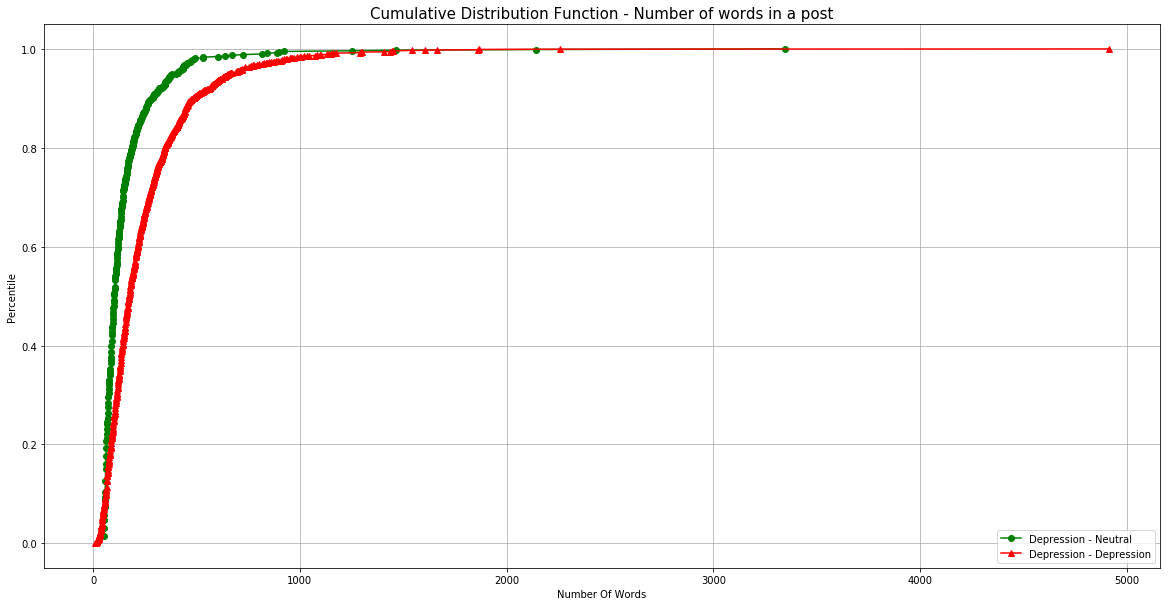

In [43]:
CDF_neutral, neutral_indice_list = generate_CDF(data=depression_group_users_neutral_posts)
CDF_depression, depression_indice_list = generate_CDF(data=depressed_group_depressed_posts)
#CDF_neutral_neutral, neutral_neutral_list = generate_CDF(data= non_depressed_people)

plt.figure(figsize=(20,10))
plt.plot(neutral_indice_list.values, CDF_neutral,color='green',marker='o', label='Depression - Neutral')
plt.plot(depression_indice_list.values, CDF_depression,color='red',marker='^', label='Depression - Depression')
#plt.plot(neutral_neutral_list.values, CDF_neutral_neutral,color='blue',marker='*', label='Neutral - Neutral')

plt.legend()
plt.title("Cumulative Distribution Function - Number of words in a post", size=15)
plt.ylabel("Percentile",size=10)
plt.xlabel("Number Of Words",size=10)
plt.grid()
plt.show()

In [44]:
# Lets drop the predicted column from our test groups
non_depressed_people = non_depressed_people.drop('predicted', axis=1)
depressed_group_depressed_posts = depressed_group_depressed_posts.drop('predicted', axis=1)

non_depressed_people['is_depressed'] = 0
depressed_group_depressed_posts['is_depressed'] = 1

In [45]:
# Combine both datasets
depressed_vs_neutral = pd.concat((non_depressed_people, depressed_group_depressed_posts), axis=0)
X = depressed_vs_neutral['post_text']
y = depressed_vs_neutral['is_depressed']

In [46]:
# Data transformation => Countvectorizer and Tfidf transformer
# removing english stopwords and analyzing on the word level
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [47]:
# Adding the trigrams to our feature matrix
tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
#X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [48]:
# Simple 80/20 ratio train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Applying a Linear Support Vector Classifier on our data
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [50]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.9276236429433052
AUC Score: 0.9731953562186524

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,449,31
actual depression,29,320


In [51]:
# Now lets try to classify and destinguish between the depression groups' neutral posts
# from the neutral group's posts
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop('predicted', axis=1)
depression_group_users_neutral_posts['is_depressed'] = 1

In [52]:
non_depressed_people = non_depressed_people.iloc[np.random.randint(non_depressed_people.shape[0], size=depression_group_users_neutral_posts.shape[0]), :]
print(depression_group_users_neutral_posts.shape)

(781, 105)


In [53]:
depressed_vs_neutral = pd.concat((non_depressed_people, depression_group_users_neutral_posts), axis=0)
depressed_vs_neutral = depressed_vs_neutral.reset_index().drop('index',axis=1)
X = depressed_vs_neutral['post_text'].map(post_to_wordlist)
X_copy = X.copy()
y = depressed_vs_neutral['is_depressed']

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word', ngram_range=(1,1))
X = count_vect.fit_transform(X)
#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 100,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)

dummy_pred = svc.predict(X_test)
confusion_matrix(y_pred=dummy_pred, y_true= y_test)

# Problem is we rely on these words as most efficient to our classifier for future use
# this is not correct since the classifier doesn't produce good output (the confusion matrix above)
feature_names = count_vect.get_feature_names()
sorted_coef_index = svc.coef_[0].argsort()[:4000]
top_keywords = list(itemgetter(*sorted_coef_index)(feature_names))
print(top_keywords[:20])

cv = CountVectorizer(stop_words='english', lowercase=True,analyzer='word', ngram_range=(1,1))
cv_matrix = cv.fit_transform(X_copy)
tfidf_transformer = TfidfTransformer()
cv_matrix = cv_matrix.toarray()
vocab = cv.get_feature_names()
vocab_df = pd.DataFrame(cv_matrix, columns=vocab)
hot_keywords = vocab_df[top_keywords]
hot_keywords = hot_keywords.divide(depressed_vs_neutral['post_length'], axis=0)

In [303]:
stopWords = set(stopwords.words('english'))

num_words = 10000
corpus = depressed_vs_neutral['post_text'].copy()
corpus = corpus.str.replace('[', '')
corpus = corpus.str.replace(']','')
corpus = corpus.str.replace('.','')
corpus = corpus.str.replace('(','')
corpus = corpus.replace(')','')
corpus_copy = corpus.copy()
corpus = corpus.str.cat().split()
corpus = [word for word in corpus if word  in stopWords]

corpus_series = pd.Series(data=corpus, name='words')
top_keywords = corpus_series.value_counts().nlargest(num_words)#(len(corpus_series.value_counts()))
# key_words = pd.DataFrame(data=np.zeros((X.shape[0], num_words)), columns=top_keywords.keys())
key_words = pd.DataFrame(data=np.zeros((X.shape[0], len(corpus_series.value_counts()))), columns=top_keywords.keys())

In [304]:
for row in range(len(corpus_copy)):
    for word in corpus_copy[row]:
        if word in key_words.columns:
            key_words[word][row] += 1
        else:
            pass

In [305]:
# Apply our CV and Tfidf on the trigrams
# Eventually, creating a large matrix comprised of the fit user normal posts and the trigrams

tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
#X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [306]:
# Adding the normalized features of post length and the number of distinct words per user

extra_features = normalize(depressed_vs_neutral[['post_length','num_distinct_words']], axis=1)
extra_features = pd.DataFrame(data=extra_features, columns=['post_length', 'num_distinct_words'])
#X = hstack((X, extra_features))

In [307]:
X = depressed_vs_neutral[liwc_cols]
print(X.shape)
X = X.reset_index().drop('index', axis=1)
X = pd.concat((X,key_words), axis=1)
X_columns = X.columns
# norm = Normalizer()
# X = norm.fit_transform(X)
X.shape

(1562, 85)


(1562, 219)

In [315]:
# pca = PCA(.95)
X = pca.fit_transform(key_words)
X.shape

(1562, 1)

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [317]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 10,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [318]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.5079872204472844
AUC Score: 0.5066349689003047

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,118,49
actual depression,105,41


In [319]:
X_train = pd.DataFrame(data=X_train, columns=np.arange(X_train.shape[1]))
coef = list(sorted(zip(X_train.columns,abs(svc.coef_[0])),key=lambda x: x[1]))
coef_table = pd.DataFrame(np.array(coef).reshape(-1,2),columns=['Attributes','Coefficient'])
print('Coefficient for every feature:\n')
#print(len(coef_table[coef_table['Coefficient'] == '0.0']))
print(coef_table)

Coefficient for every feature:

   Attributes  Coefficient
0         0.0       0.0174


In [320]:
for i in coef_table.Attributes:
    print("Variance for {} vector: {}".format(i,pca.explained_variance_ratio_[int(i)]))

Variance for 0.0 vector: 0.9676304050232701


###### Print Smallest and Largest important feature words
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [65]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))
        
no_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(depression_group_users_neutral_posts['post_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(depression_group_users_neutral_posts['post_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [66]:
no_topics = 10

nmf = NMF(n_components=no_topics, random_state = 42, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=42)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [67]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
print("-------------------------------")
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
like just know dont want really time people ive feel
Topic 1:
remember movie film think watched girl scene ago believe kid
Topic 2:
https com www youtube watch imgur http twitter youtu videos
Topic 3:
games game played playing play video gaming fallout old xbox
Topic 4:
im ive looking starting college really answer sure dont doesnt
Topic 5:
song music like rock heard video sounds youtu album voice
Topic 6:
que em um da não ou uma para tem eu
Topic 7:
magic crystal crystals elemental energy nature blood magical does power
Topic 8:
adds steamcommunity filedetails sharedfiles add http id com private moment
Topic 9:
group meeting people tips split doesn experiences event anxiety minutes
-------------------------------
Topic 0:
duh match dog ending tried season like really don note
Topic 1:
like just im time know think dont game want really
Topic 2:
dm food electrons 2018 law freedom standing warlock running speech
Topic 3:
com https www http youtube just google imgur id watch
Topi

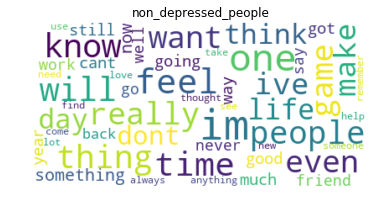

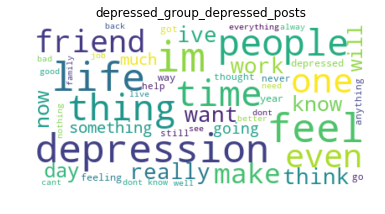

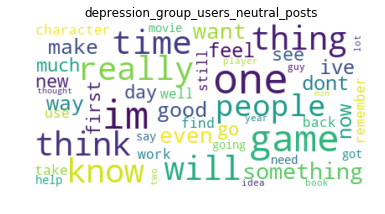

In [68]:
# Generate Word Clouds for each group
texts = [non_depressed_people, depressed_group_depressed_posts, depression_group_users_neutral_posts]
titles = ['non_depressed_people', 'depressed_group_depressed_posts', 'depression_group_users_neutral_posts']
for i,x in zip(texts,titles):
    generate_wordcloud(text=i,title=x)

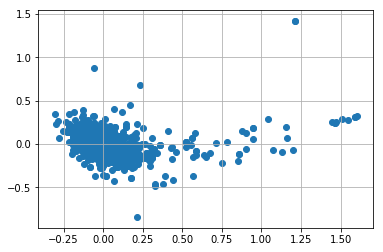

In [69]:
liwc_temp_df = depressed_vs_neutral[liwc_cols].copy()
pca = PCA(n_components=2)

liwc_temp_df = pca.fit_transform(liwc_temp_df)
liwc_temp_df.shape
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0], y=liwc_temp_df[:, 1])
plt.grid()
plt.show()

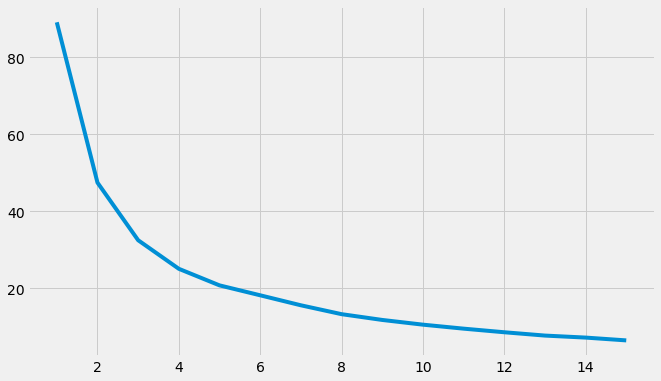

In [70]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(liwc_temp_df)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.show()


In [71]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(liwc_temp_df)


1    781
0    781
Name: is_depressed, dtype: int64


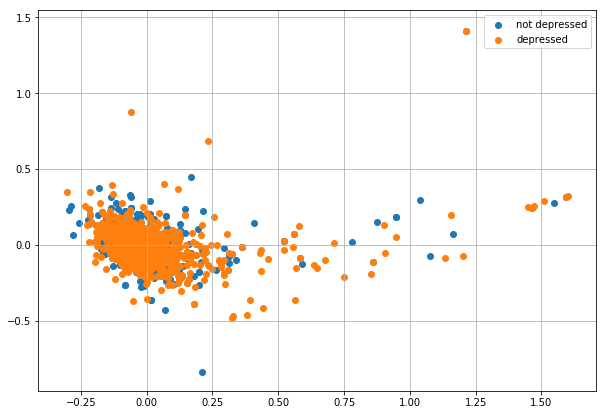

In [72]:
liwc_temp_df = np.column_stack((liwc_temp_df, depressed_vs_neutral['is_depressed'].values))
print(depressed_vs_neutral['is_depressed'].value_counts())
plt.figure(figsize=(10,7))
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0][liwc_temp_df[:,2] == 0], y=liwc_temp_df[:,1][liwc_temp_df[:,2] == 0], label='not depressed')
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0][liwc_temp_df[:,2] == 1], y=liwc_temp_df[:,1][liwc_temp_df[:,2] == 1], label='depressed')
plt.grid()
plt.legend()
plt.show()

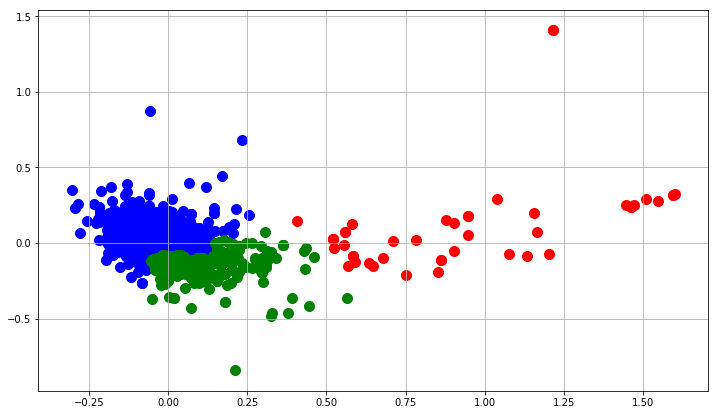

In [73]:
plt.figure(figsize=(12,7))
plt.scatter(liwc_temp_df[y_hc == 0, 0],liwc_temp_df[y_hc == 0, 1] , s = 100, c = 'red')
plt.scatter(liwc_temp_df[y_hc == 1, 0],liwc_temp_df[y_hc == 1, 1] , s = 100, c = 'blue')
plt.scatter(liwc_temp_df[y_hc == 2, 0],liwc_temp_df[y_hc == 2, 1] , s = 100, c = 'green')
plt.grid(True)
plt.show()

In [74]:
#X = depressed_vs_neutral['post_text']
#y = depressed_vs_neutral['is_depressed']
#X = liwc_temp_df
#count_vect = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(2,2), lowercase=True, binary=True)
#X  = count_vect.fit_transform(X)

In [261]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
vocab_size = 1000
corpus = depressed_vs_neutral['post_text'].copy()
encoded_corpus = [one_hot(d, vocab_size) for d in corpus]

# pad corpus
max_length = 1000
padded_docs = pad_sequences(encoded_corpus, maxlen=max_length, padding='post')

In [262]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size = 0.2, random_state = 42)
print(X_train.shape[0])

1249


In [275]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, regularizers, Embedding, Flatten

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(Flatten())

model.add(Dense(1000, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(500, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(500, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [276]:
# Using binary crossentropy loss function because we have a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

['loss', 'acc']


In [277]:
batch_size = 1024
n_epohcs = 30

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epohcs, verbose=True, validation_split=0.1)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=True)

Train on 1124 samples, validate on 125 samples
Epoch 1/30
1124/1124 [==============================] - 2s 2ms/step - loss: 0.7058 - acc: 0.5151 - val_loss: 0.6942 - val_acc: 0.4960
Epoch 2/30
1124/1124 [==============================] - 1s 957us/step - loss: 0.6947 - acc: 0.4947 - val_loss: 0.7065 - val_acc: 0.4880
Epoch 3/30
1124/1124 [==============================] - 1s 946us/step - loss: 0.7001 - acc: 0.5142 - val_loss: 0.6935 - val_acc: 0.5040
Epoch 4/30
1124/1124 [==============================] - 1s 948us/step - loss: 0.6943 - acc: 0.4822 - val_loss: 0.7034 - val_acc: 0.5040
Epoch 5/30
1124/1124 [==============================] - 1s 935us/step - loss: 0.7055 - acc: 0.4938 - val_loss: 0.6937 - val_acc: 0.4880
Epoch 6/30
1124/1124 [==============================] - 1s 933us/step - loss: 0.6904 - acc: 0.5187 - val_loss: 0.7029 - val_acc: 0.4880
Epoch 7/30
1124/1124 [==============================] - 1s 918us/step - loss: 0.6926 - acc: 0.5151 - val_loss: 0.6928 - val_acc: 0.5120
Epo

In [280]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", scores[1]) 

313/313 [==============================] - 0s 671us/step
Accuracy: 0.5175718868883273


In [281]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
model.summary()

[[108  59]
 [ 92  54]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 10)          10000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              10001000  
_________________________________________________________________
activation_17 (Activation)   (None, 1000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 500)               500500    
_________________________________________________________________
activation_18 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 500)             

###### Future code block for creating a new liwc dataframe
temp_df = full_df[full_df['post_length'] > 0][['post_text','submission_id']].copy()
for i in liwc_cols:
    temp_df[i] = i
temp_df = temp_df.reset_index().drop('index',axis=1)
temp_df.head()

##### Run this block if you want to create an LIWC dataframe
liwc_obj = liwc_analysis(temp_df['post_text'][0])

temp = pd.DataFrame(data=liwc_obj, index=[0])
blu = pd.Series(data=temp_df['submission_id'][0],name='submission_id')
temp = pd.concat((temp,blu),axis=1)
for i in range(1, len(temp_df)):
    print(i)
    text = liwc_analysis(temp_df['post_text'][i])
    temp_obj = pd.DataFrame(data=text, index=[0])
    temp_series = pd.Series(data=full_df['submission_id'][i], name='submission_id')
    temp_obj = pd.concat((temp_obj, temp_series), axis=1)
    temp = pd.concat((temp, temp_obj), axis=0)


temp.to_csv('temp2.csv')


In [282]:
from gensim.models import word2vec
import multiprocessing
num_features = 100   # Dimensionality of the hidden layer representation
min_word_count = 40   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()      # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3

print("Training model...")
model = word2vec.Word2Vec(depressed_vs_neutral.post_text, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

Training model...


In [283]:
Z = model.wv.syn0

print(Z[0].shape)
Z.shape

(100,)


(72, 100)